In [1]:
import pandas as pd
import numpy as np

In [4]:
path = "./PRSA_data_2010.1.1-2014.12.31.csv"
df = pd.read_csv(path)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [35]:
df['log pm2.5'] = df['pm2.5'].map(lambda x : np.log(x) if x > 0 else x)

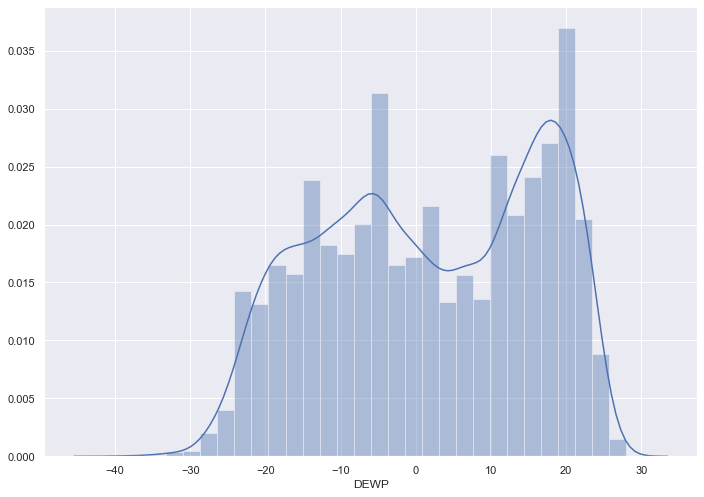

In [132]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['DEWP'], bins=30)
plt.show()

In [42]:
df = df.drop('No', axis=1)

In [49]:
from numpy import nan as NaN

In [51]:
df = df.dropna()

In [55]:
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,log pm2.5
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,4.859812
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,4.997212
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,5.068904
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,5.198497
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4.927254


In [ ]:
import datetime

In [89]:
season_book = {
    "spring equinox": [3, 21],
    "autumn equinox": [9, 23],
    "summer solstice": [6, 22],
    "winter solstice": [12, 22]
}

In [91]:
def convert_year_to_season(year: float, month: float, day:float, season_book: dict) -> int:
#     actual_date = datetime.datetime(int(year), int(month), int(hour))
    if (month < season_book["spring equinox"][0] and day < season_book["spring equinox"][1]) \
        or (month >= season_book["winter solstice"][0] and day >= season_book["winter solstice"][1]):
        return 0 # winter
    elif (month >= season_book["spring equinox"][0] and day >= season_book["spring equinox"][1]) \
        or (month < season_book["summer solstice"][0] and day < season_book["summer solstice"][1]):
        return 1 # spring
    elif (month >= season_book["summer solstice"][0] and day >= season_book["summer solstice"][1]) \
        or (month < season_book["autumn equinox"][0] and day < season_book["autumn equinox"][1]):
        return 2
    else:
        return 3

In [95]:
convert_year_to_season(2022, 12,12, season_book)

3

In [100]:
df['season'] = df[['year','month','day']].apply(
    lambda x: convert_year_to_season(x['year'], x['month'], x['day'], season_book), axis=1)

In [101]:
df['season'].head()

24    0
25    0
26    0
27    0
28    0
Name: season, dtype: int64

In [112]:
df['Iws_delta'] = df['Iws'].diff()
df['Iws_delta'][df.index == 24] = 1.79

/Users/kele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
df['Iws_delta']

24       1.79
25       0.89
26       0.89
27       1.79
28       0.89
         ... 
43819    5.81
43820    5.81
43821    4.92
43822    4.02
43823    3.13
Name: Iws_delta, Length: 41757, dtype: float64

In [124]:
df['Ir_p'] = df['Ir'].map(lambda x: int(x > 0))
df['Is_p'] = df['Is'].map(lambda x: int(x > 0))

In [129]:
def hours_split(hour: float) -> int:
    actual_hour = int(hour)
    if actual_hour > 2 and actual_hour <= 6:
        return 0
    elif actual_hour > 6 and actual_hour <= 10:
        return 1
    elif actual_hour > 10 and actual_hour <= 14:
        return 2
    elif actual_hour > 14 and actual_hour <= 18:
        return 3
    elif actual_hour > 18 and actual_hour <= 22:
        return 4
    else:
        return 5

In [130]:
df['hour_range'] = df['hour'].map(hours_split)

In [131]:
df.columns

Index(['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd',
       'Iws', 'Is', 'Ir', 'log pm2.5', 'season', 'Iws_delta', 'Ir_p', 'Is_p',
       'hour_range'],
      dtype='object')

In [136]:
df_processed = df.drop(['year','month', 'day','hour','Iws','Is','Ir','pm2.5'], axis=1)

In [147]:
cbwd_oh = pd.get_dummies(df_processed['cbwd'],prefix="cbwd")
season_oh = pd.get_dummies(df_processed['season'],prefix="season")
hour_range_oh = pd.get_dummies(df_processed['hour_range'],prefix="hour_range")

In [148]:
df_oh_new = pd.concat([df_processed, cbwd_oh, season_oh, hour_range_oh], axis=1)

In [149]:
df_oh = df_oh_new.drop(['cbwd','season','hour_range'], axis=1)

In [154]:
df_oh.columns

Index(['DEWP', 'TEMP', 'PRES', 'log pm2.5', 'Iws_delta', 'Ir_p', 'Is_p',
       'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'season_0', 'season_1',
       'season_2', 'season_3', 'hour_range_0', 'hour_range_1', 'hour_range_2',
       'hour_range_3', 'hour_range_4', 'hour_range_5'],
      dtype='object')

In [153]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [196]:
training_portion = 0.9
testing_set = 0.1
samples = df_oh.__len__()
training_set = df_oh[:int(samples * training_portion)]
testing_set = df_oh[int(samples * training_portion):]

In [197]:
scaler = MinMaxScaler() 
scaler.fit(training_set[['Iws_delta','DEWP', 'TEMP', 'PRES']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [210]:
scaled_training_set = scaler.transform(training_set[['Iws_delta','DEWP', 'TEMP', 'PRES']])
scaled_testing_set = scaler.transform(testing_set[['Iws_delta','DEWP', 'TEMP', 'PRES']])

In [211]:
training_y = training_set['log pm2.5'].values
testing_y = testing_set['log pm2.5'].values
training_X = training_set.drop(['log pm2.5','Iws_delta','DEWP', 'TEMP', 'PRES'], axis=1).values
testing_X = testing_set.drop(['log pm2.5','Iws_delta','DEWP', 'TEMP', 'PRES'], axis=1).values
scaled_training_X = np.concatenate([training_X.data, scaled_training_set], axis=1)
scaled_testing_X = np.concatenate([testing_X.data, scaled_testing_set], axis=1)

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [225]:
sgdr = SGDRegressor().fit(scaled_training_X, training_y)

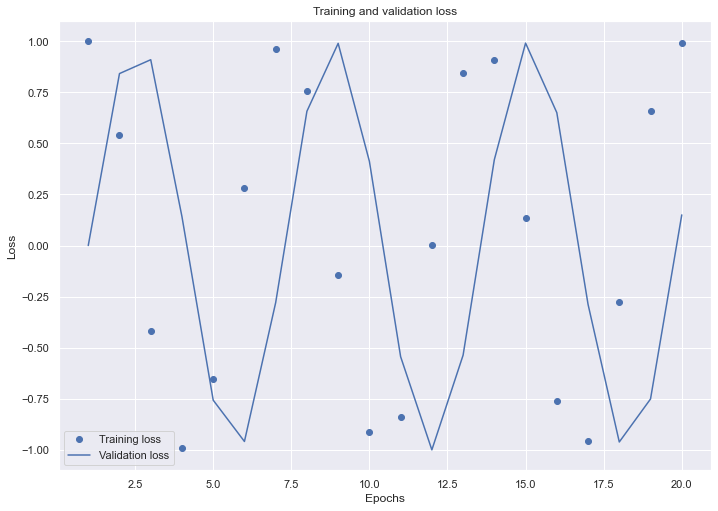

In [230]:
perp = range(20)
epochs = range(1, len(perp) + 1)
l1 = np.cos(prep)
l2 = np.sin(prep)
# "bo" is for "blue dot"
plt.plot(epochs, l1, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, l2, 'b*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("testing_pic.jpg")
plt.show()

In [213]:
model = LinearRegression()
model.fit(scaled_training_X, training_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [174]:
from sklearn.metrics import mean_squared_error

In [216]:
training_pred_y = model.predict(scaled_training_X)

In [220]:
np.sqrt(mean_squared_error(np.exp(training_pred_y), np.exp(training_y)))

82.68632935919733

In [214]:
testing_pred_y = model.predict(scaled_testing_X)

In [219]:
np.sqrt(mean_squared_error(np.exp(testing_pred_y), np.exp(testing_y)))

73.53719729847681

array([-5.10544001e-01, -3.17339948e-01, -9.09147278e+10, -9.09147278e+10,
       -9.09147278e+10, -9.09147278e+10,  1.76955659e+11,  1.76955659e+11,
        1.76955659e+11,  1.76955659e+11, -1.01365309e+11, -1.01365309e+11,
       -1.01365309e+11, -1.01365309e+11, -1.01365309e+11, -1.01365309e+11,
        1.35625189e+00,  4.70648909e+00, -5.47226033e+00, -1.47285844e+00])